# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Extracting mnist: 100%|██████████| 60.0K/60.0K [00:07<00:00, 8.37KFile/s]


Extracting celeba...


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

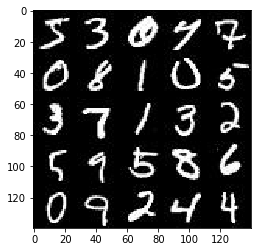

In [1]:
import helper

show_n_images = 25
data_dir = './data'

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

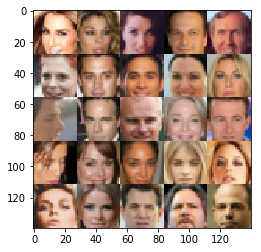

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [3]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.2.1


C:\Users\Kurosaki-X\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\ipykernel\__main__.py:14: UserWarning: No GPU found. Please use a GPU to train your neural network.


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [4]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    real_input = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name='real_input')
    z_input = tf.placeholder(tf.float32, [None, z_dim], name='z_input')
    learning_rate = tf.placeholder(tf.float32, name='learning_rate', shape=())
    
    return real_input, z_input, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [5]:
def discriminator(images, reuse=False, alpha=0.2):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    #https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    with tf.variable_scope("discriminator", reuse=reuse):
        out1 = tf.layers.conv2d(images, 64, 5, strides=2, padding='SAME')
        relu1 = tf.maximum(alpha * out1, out1)
        drop1 = tf.layers.dropout(relu1, rate=0.4)
        
        out2 = tf.layers.conv2d(drop1, 128, 5, strides=2, padding='SAME')
        norm2 = tf.layers.batch_normalization(out2, training=True)
        relu2 = tf.maximum(alpha * norm2, norm2)
        drop2 = tf.layers.dropout(relu2, rate=0.4)
        
        out3 = tf.layers.conv2d(drop2, 256, 5, strides=2, padding='SAME')
        norm3 = tf.layers.batch_normalization(out3, training=True)
        relu3 = tf.maximum(alpha * norm3, norm3)
        drop3 = tf.layers.dropout(relu3, rate=0.4)
        
        flat = tf.reshape(drop3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [6]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    #https://medium.com/towards-data-science/gan-by-example-using-keras-on-tensorflow-backend-1a6d515a60d0
    reuse = not is_train
    
    with tf.variable_scope("generator", reuse=reuse):
        out1 = tf.layers.dense(z, 7*7*512)
        
        out1 = tf.reshape(out1, (-1, 7, 7, 512))
        norm1 = tf.layers.batch_normalization(out1, training=is_train, momentum=0.9)
        relu1 = tf.maximum(alpha * norm1, norm1)
        drop1 = tf.layers.dropout(relu1)
        
        out2 = tf.layers.conv2d_transpose(drop1, 256, 5, strides=2, padding='SAME')
        norm2 = tf.layers.batch_normalization(out2, training=is_train, momentum=0.9)
        relu2 = tf.maximum(alpha * norm2, norm2)

        out3 = tf.layers.conv2d_transpose(relu2, 128, 5, strides=2, padding='SAME')
        norm3 = tf.layers.batch_normalization(out3, training=is_train, momentum=0.9)
        relu3 = tf.maximum(alpha * norm3, norm3)
        
        logits = tf.layers.conv2d_transpose(relu3, out_channel_dim, 5, strides=1, padding='SAME')
        output = tf.tanh(logits)
        
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [7]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    #base on DCGAN.ipynb
    ger_model = generator(input_z, out_channel_dim)
    dis_model_real, dis_logits_real = discriminator(input_real)
    dis_model_fake, dis_logits_fake = discriminator(ger_model, reuse=True)
    
    dis_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_real, labels=tf.ones_like(dis_model_real) * 0.9))
    dis_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.zeros_like(dis_model_fake)))
    ger_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=dis_logits_fake, labels=tf.ones_like(dis_model_fake)))
    
    dis_loss = dis_loss_real + dis_loss_fake
    
    return dis_loss, ger_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [8]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        train_vars = tf.trainable_variables()
        
        dis_vars = [var for var in train_vars if var.name.startswith("discriminator")]
        ger_vars = [var for var in train_vars if var.name.startswith("generator")]

        dis_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dis_vars)
        ger_train = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=ger_vars)
        
    return dis_train, ger_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [9]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [10]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #based on DCGAN.ipynb
    output_channel_dim = data_shape[3]
    real_input, z_input, tf_learnrate = model_inputs(data_shape[1], data_shape[2], output_channel_dim, z_dim)
    d_loss, g_loss = model_loss(real_input, z_input, output_channel_dim)
    dis_train, ger_train = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for step, batch_images in enumerate(get_batches(batch_size)):
                
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))
                _ = sess.run(dis_train, feed_dict={real_input: batch_images, z_input: batch_z, tf_learnrate: learning_rate})
                _ = sess.run(ger_train, feed_dict={z_input: batch_z, real_input: batch_images, tf_learnrate: learning_rate})
                
                if step % 10 == 0:
                    train_loss_dis = d_loss.eval({z_input: batch_z, real_input: batch_images})
                    train_loss_ger = g_loss.eval({z_input: batch_z})
                
                    print("Epoch {}/{}...".format(epoch_i+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dis),
                          "Generator Loss: {:.4f}".format(train_loss_ger))
                
                if step % 100 == 0:
                    show_generator_output(sess, 4, z_input, output_channel_dim, data_image_mode)
                    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 11.8370... Generator Loss: 0.0001


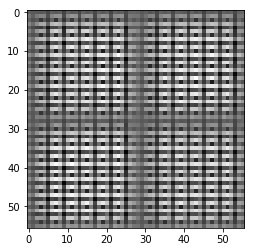

Epoch 1/2... Discriminator Loss: 0.8647... Generator Loss: 26.3647
Epoch 1/2... Discriminator Loss: 8.3151... Generator Loss: 0.0579
Epoch 1/2... Discriminator Loss: 0.9366... Generator Loss: 1.4380
Epoch 1/2... Discriminator Loss: 1.8322... Generator Loss: 0.3555
Epoch 1/2... Discriminator Loss: 0.8304... Generator Loss: 1.5236
Epoch 1/2... Discriminator Loss: 1.1217... Generator Loss: 0.9041
Epoch 1/2... Discriminator Loss: 1.4588... Generator Loss: 3.2253
Epoch 1/2... Discriminator Loss: 0.8252... Generator Loss: 1.1052
Epoch 1/2... Discriminator Loss: 0.4212... Generator Loss: 2.8431
Epoch 1/2... Discriminator Loss: 0.3518... Generator Loss: 5.2515


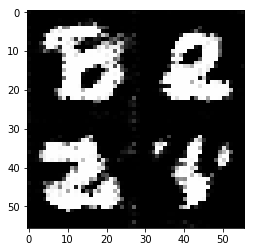

Epoch 1/2... Discriminator Loss: 2.4170... Generator Loss: 7.1168
Epoch 1/2... Discriminator Loss: 0.8495... Generator Loss: 1.3166
Epoch 1/2... Discriminator Loss: 0.4462... Generator Loss: 2.5325
Epoch 1/2... Discriminator Loss: 0.3791... Generator Loss: 3.4950
Epoch 1/2... Discriminator Loss: 0.3460... Generator Loss: 6.1778
Epoch 1/2... Discriminator Loss: 0.3808... Generator Loss: 3.5601
Epoch 1/2... Discriminator Loss: 0.8963... Generator Loss: 4.8574
Epoch 1/2... Discriminator Loss: 0.9800... Generator Loss: 0.8076
Epoch 1/2... Discriminator Loss: 0.5530... Generator Loss: 2.5139
Epoch 1/2... Discriminator Loss: 0.5662... Generator Loss: 1.8427


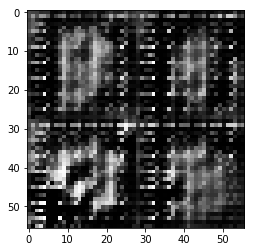

Epoch 1/2... Discriminator Loss: 0.3492... Generator Loss: 4.4839
Epoch 1/2... Discriminator Loss: 0.4226... Generator Loss: 2.8311
Epoch 1/2... Discriminator Loss: 3.1606... Generator Loss: 6.9094
Epoch 1/2... Discriminator Loss: 0.4218... Generator Loss: 3.0067
Epoch 1/2... Discriminator Loss: 0.6636... Generator Loss: 1.3708
Epoch 1/2... Discriminator Loss: 0.5645... Generator Loss: 1.7322
Epoch 1/2... Discriminator Loss: 0.4086... Generator Loss: 3.8617
Epoch 1/2... Discriminator Loss: 0.3928... Generator Loss: 4.2463
Epoch 1/2... Discriminator Loss: 0.3414... Generator Loss: 6.1110
Epoch 1/2... Discriminator Loss: 4.1770... Generator Loss: 0.0712


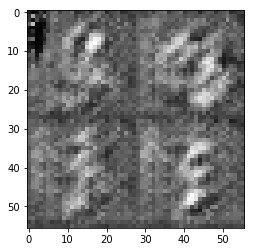

Epoch 1/2... Discriminator Loss: 1.7765... Generator Loss: 3.1521
Epoch 1/2... Discriminator Loss: 1.3853... Generator Loss: 0.5703
Epoch 1/2... Discriminator Loss: 0.5913... Generator Loss: 2.3212
Epoch 1/2... Discriminator Loss: 0.5380... Generator Loss: 2.6542
Epoch 1/2... Discriminator Loss: 2.1109... Generator Loss: 0.2405
Epoch 1/2... Discriminator Loss: 0.5940... Generator Loss: 4.5775
Epoch 1/2... Discriminator Loss: 0.3941... Generator Loss: 4.6149
Epoch 1/2... Discriminator Loss: 0.4564... Generator Loss: 3.8206
Epoch 1/2... Discriminator Loss: 0.4259... Generator Loss: 3.3738
Epoch 1/2... Discriminator Loss: 1.1610... Generator Loss: 1.5208


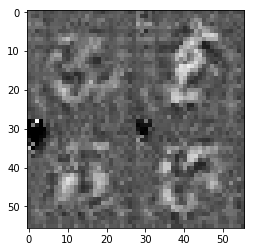

Epoch 1/2... Discriminator Loss: 0.4282... Generator Loss: 4.0576
Epoch 1/2... Discriminator Loss: 0.3708... Generator Loss: 4.3515
Epoch 1/2... Discriminator Loss: 0.4569... Generator Loss: 2.8301
Epoch 1/2... Discriminator Loss: 2.2155... Generator Loss: 0.2506
Epoch 1/2... Discriminator Loss: 0.6263... Generator Loss: 2.0400
Epoch 1/2... Discriminator Loss: 1.5072... Generator Loss: 0.6393
Epoch 2/2... Discriminator Loss: 1.2676... Generator Loss: 2.3847


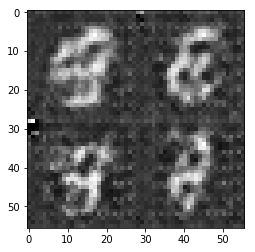

Epoch 2/2... Discriminator Loss: 0.9597... Generator Loss: 2.1580
Epoch 2/2... Discriminator Loss: 0.5653... Generator Loss: 2.3676
Epoch 2/2... Discriminator Loss: 0.3898... Generator Loss: 5.1062
Epoch 2/2... Discriminator Loss: 0.3861... Generator Loss: 4.3649
Epoch 2/2... Discriminator Loss: 0.4083... Generator Loss: 3.8503
Epoch 2/2... Discriminator Loss: 0.3727... Generator Loss: 4.7533
Epoch 2/2... Discriminator Loss: 0.3804... Generator Loss: 4.6765
Epoch 2/2... Discriminator Loss: 0.5426... Generator Loss: 3.1223
Epoch 2/2... Discriminator Loss: 0.3509... Generator Loss: 5.2767
Epoch 2/2... Discriminator Loss: 0.4217... Generator Loss: 6.9401


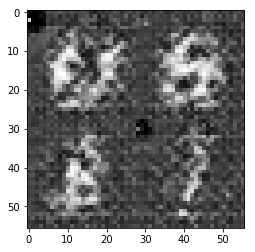

Epoch 2/2... Discriminator Loss: 0.3684... Generator Loss: 4.4417
Epoch 2/2... Discriminator Loss: 1.9355... Generator Loss: 2.1470
Epoch 2/2... Discriminator Loss: 1.1147... Generator Loss: 0.8954
Epoch 2/2... Discriminator Loss: 1.0721... Generator Loss: 0.8797
Epoch 2/2... Discriminator Loss: 0.9526... Generator Loss: 2.1036
Epoch 2/2... Discriminator Loss: 1.1211... Generator Loss: 2.9804
Epoch 2/2... Discriminator Loss: 0.7303... Generator Loss: 2.9150
Epoch 2/2... Discriminator Loss: 0.4167... Generator Loss: 3.5916
Epoch 2/2... Discriminator Loss: 0.4143... Generator Loss: 4.2853
Epoch 2/2... Discriminator Loss: 0.3731... Generator Loss: 4.5408


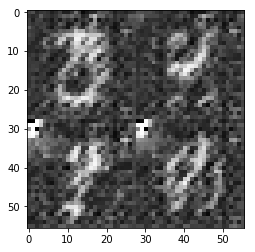

Epoch 2/2... Discriminator Loss: 0.3910... Generator Loss: 3.9159
Epoch 2/2... Discriminator Loss: 0.4179... Generator Loss: 3.7185
Epoch 2/2... Discriminator Loss: 2.8947... Generator Loss: 0.4036
Epoch 2/2... Discriminator Loss: 0.5240... Generator Loss: 3.9034
Epoch 2/2... Discriminator Loss: 0.4936... Generator Loss: 2.6303
Epoch 2/2... Discriminator Loss: 0.6345... Generator Loss: 1.7837
Epoch 2/2... Discriminator Loss: 2.0412... Generator Loss: 0.2802
Epoch 2/2... Discriminator Loss: 1.5294... Generator Loss: 0.4699
Epoch 2/2... Discriminator Loss: 1.3075... Generator Loss: 0.6295
Epoch 2/2... Discriminator Loss: 0.4208... Generator Loss: 3.4158


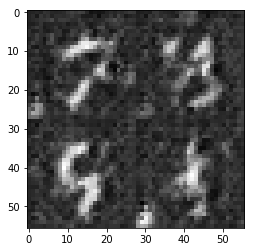

Epoch 2/2... Discriminator Loss: 0.5323... Generator Loss: 1.9458
Epoch 2/2... Discriminator Loss: 0.4567... Generator Loss: 2.3985
Epoch 2/2... Discriminator Loss: 0.9555... Generator Loss: 0.9699
Epoch 2/2... Discriminator Loss: 0.8081... Generator Loss: 1.6800
Epoch 2/2... Discriminator Loss: 0.5114... Generator Loss: 2.3258
Epoch 2/2... Discriminator Loss: 0.4673... Generator Loss: 2.3078
Epoch 2/2... Discriminator Loss: 1.3339... Generator Loss: 0.5330
Epoch 2/2... Discriminator Loss: 0.4813... Generator Loss: 2.2131
Epoch 2/2... Discriminator Loss: 0.4486... Generator Loss: 2.4055
Epoch 2/2... Discriminator Loss: 1.4540... Generator Loss: 0.6321


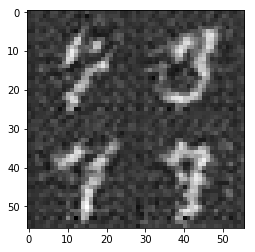

Epoch 2/2... Discriminator Loss: 2.6707... Generator Loss: 0.1429
Epoch 2/2... Discriminator Loss: 0.8888... Generator Loss: 1.0742
Epoch 2/2... Discriminator Loss: 1.8030... Generator Loss: 0.3188
Epoch 2/2... Discriminator Loss: 0.6668... Generator Loss: 3.5392
Epoch 2/2... Discriminator Loss: 1.7560... Generator Loss: 0.3169
Epoch 2/2... Discriminator Loss: 0.7312... Generator Loss: 1.4624


In [ ]:
batch_size = 128
z_dim = 120
learning_rate = 0.001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 16.9941... Generator Loss: 0.0000


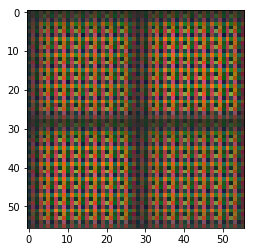

Epoch 1/1... Discriminator Loss: 4.1162... Generator Loss: 0.0350
Epoch 1/1... Discriminator Loss: 0.5162... Generator Loss: 2.8422
Epoch 1/1... Discriminator Loss: 0.4747... Generator Loss: 3.1210
Epoch 1/1... Discriminator Loss: 1.0745... Generator Loss: 0.9649
Epoch 1/1... Discriminator Loss: 1.2533... Generator Loss: 3.5242
Epoch 1/1... Discriminator Loss: 0.8090... Generator Loss: 1.3331
Epoch 1/1... Discriminator Loss: 0.4544... Generator Loss: 3.6281
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.3658
Epoch 1/1... Discriminator Loss: 0.3670... Generator Loss: 8.1484
Epoch 1/1... Discriminator Loss: 0.4078... Generator Loss: 3.3341


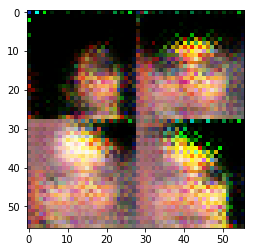

Epoch 1/1... Discriminator Loss: 0.6075... Generator Loss: 2.8589
Epoch 1/1... Discriminator Loss: 0.4826... Generator Loss: 2.3719
Epoch 1/1... Discriminator Loss: 0.5918... Generator Loss: 2.2987
Epoch 1/1... Discriminator Loss: 0.6381... Generator Loss: 2.7862
Epoch 1/1... Discriminator Loss: 0.4676... Generator Loss: 2.5488
Epoch 1/1... Discriminator Loss: 0.3475... Generator Loss: 6.2478
Epoch 1/1... Discriminator Loss: 1.0216... Generator Loss: 1.3938
Epoch 1/1... Discriminator Loss: 0.5664... Generator Loss: 1.8657
Epoch 1/1... Discriminator Loss: 0.8482... Generator Loss: 1.4416
Epoch 1/1... Discriminator Loss: 0.6480... Generator Loss: 1.8466


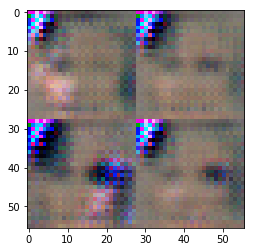

Epoch 1/1... Discriminator Loss: 2.2491... Generator Loss: 0.2642
Epoch 1/1... Discriminator Loss: 0.7588... Generator Loss: 1.3423
Epoch 1/1... Discriminator Loss: 0.5766... Generator Loss: 3.1370
Epoch 1/1... Discriminator Loss: 1.9425... Generator Loss: 0.4048
Epoch 1/1... Discriminator Loss: 1.1857... Generator Loss: 0.9992
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.7427
Epoch 1/1... Discriminator Loss: 1.2919... Generator Loss: 1.2880
Epoch 1/1... Discriminator Loss: 1.3161... Generator Loss: 2.0889
Epoch 1/1... Discriminator Loss: 0.5954... Generator Loss: 2.0027
Epoch 1/1... Discriminator Loss: 0.8830... Generator Loss: 1.2181


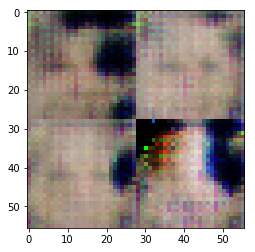

Epoch 1/1... Discriminator Loss: 0.5983... Generator Loss: 1.9686
Epoch 1/1... Discriminator Loss: 3.3128... Generator Loss: 7.1442
Epoch 1/1... Discriminator Loss: 0.5201... Generator Loss: 2.1857
Epoch 1/1... Discriminator Loss: 0.9608... Generator Loss: 1.5807
Epoch 1/1... Discriminator Loss: 5.2778... Generator Loss: 2.8808
Epoch 1/1... Discriminator Loss: 1.2259... Generator Loss: 1.0814
Epoch 1/1... Discriminator Loss: 1.0846... Generator Loss: 1.0706
Epoch 1/1... Discriminator Loss: 1.2432... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 0.9312... Generator Loss: 1.2703
Epoch 1/1... Discriminator Loss: 0.4814... Generator Loss: 2.8450


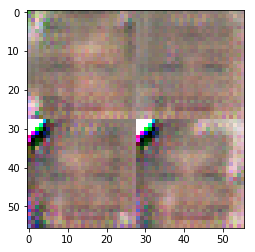

Epoch 1/1... Discriminator Loss: 0.4566... Generator Loss: 3.3208
Epoch 1/1... Discriminator Loss: 1.4454... Generator Loss: 1.1703
Epoch 1/1... Discriminator Loss: 0.9391... Generator Loss: 1.4574
Epoch 1/1... Discriminator Loss: 0.9250... Generator Loss: 1.2871
Epoch 1/1... Discriminator Loss: 0.7125... Generator Loss: 1.6204
Epoch 1/1... Discriminator Loss: 1.1140... Generator Loss: 4.0918
Epoch 1/1... Discriminator Loss: 1.0832... Generator Loss: 1.2038
Epoch 1/1... Discriminator Loss: 0.8608... Generator Loss: 2.3076
Epoch 1/1... Discriminator Loss: 0.4794... Generator Loss: 2.3596
Epoch 1/1... Discriminator Loss: 0.4563... Generator Loss: 3.5339


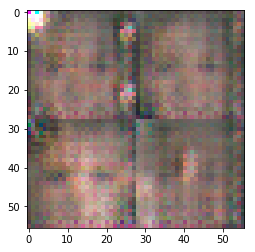

Epoch 1/1... Discriminator Loss: 1.0030... Generator Loss: 1.1396
Epoch 1/1... Discriminator Loss: 0.7648... Generator Loss: 2.0937
Epoch 1/1... Discriminator Loss: 0.4759... Generator Loss: 2.5067
Epoch 1/1... Discriminator Loss: 0.5335... Generator Loss: 2.1120
Epoch 1/1... Discriminator Loss: 0.4425... Generator Loss: 2.9939
Epoch 1/1... Discriminator Loss: 0.5095... Generator Loss: 3.4753
Epoch 1/1... Discriminator Loss: 0.5195... Generator Loss: 2.1756
Epoch 1/1... Discriminator Loss: 0.5305... Generator Loss: 2.6773
Epoch 1/1... Discriminator Loss: 0.4184... Generator Loss: 3.5996
Epoch 1/1... Discriminator Loss: 0.9422... Generator Loss: 2.3405


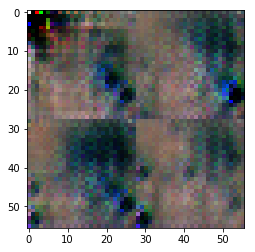

Epoch 1/1... Discriminator Loss: 1.0512... Generator Loss: 3.3225
Epoch 1/1... Discriminator Loss: 0.4752... Generator Loss: 2.5340
Epoch 1/1... Discriminator Loss: 0.4263... Generator Loss: 3.2993
Epoch 1/1... Discriminator Loss: 0.4512... Generator Loss: 2.8712
Epoch 1/1... Discriminator Loss: 0.3626... Generator Loss: 4.7991
Epoch 1/1... Discriminator Loss: 1.1171... Generator Loss: 1.0248
Epoch 1/1... Discriminator Loss: 0.4038... Generator Loss: 3.7627
Epoch 1/1... Discriminator Loss: 0.3863... Generator Loss: 3.9757
Epoch 1/1... Discriminator Loss: 0.4133... Generator Loss: 3.2886
Epoch 1/1... Discriminator Loss: 0.4156... Generator Loss: 3.1933


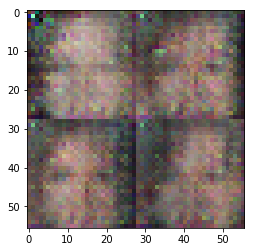

Epoch 1/1... Discriminator Loss: 0.3760... Generator Loss: 4.7054
Epoch 1/1... Discriminator Loss: 0.9805... Generator Loss: 4.1193
Epoch 1/1... Discriminator Loss: 0.4106... Generator Loss: 3.0476
Epoch 1/1... Discriminator Loss: 0.5004... Generator Loss: 2.2198
Epoch 1/1... Discriminator Loss: 0.3734... Generator Loss: 4.3040
Epoch 1/1... Discriminator Loss: 1.7771... Generator Loss: 7.0367
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 1.6699
Epoch 1/1... Discriminator Loss: 1.0360... Generator Loss: 1.1726
Epoch 1/1... Discriminator Loss: 0.5911... Generator Loss: 2.1622


In [ ]:
batch_size = 128
z_dim = 120
learning_rate = 0.001
beta1 = 0.4

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.